## Testing original network KPIs

In [1]:
# code to run a SUMO traffic simulation with TraCI interface

import traci
import os
import sys
import keyboard
import time

# --- Configuration ---
# Define the path 
project_path = r"Original network/"

# Change path to working directory
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"working directory: {os.getcwd()}")
else:
    sys.exit(f"Path {project_path} does not exist.")

# --- Configuration ---
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

sumoBinary = "sumo-gui"  # Use 'sumo-gui' to see the simulation
sumoCmd = [sumoBinary, "-c", "ff_heterogeneous.sumocfg", "--start", "--quit-on-end"]

def run_simulation():
    traci.start(sumoCmd)

    while traci.simulation.getTime() <= 3600:
        traci.simulationStep() # Advance by one second (or one step)
        
        sim_time = traci.simulation.getTime()

        # Optional: Manual exit with the 'q' key
        if keyboard.is_pressed('q'):
            break
            
    traci.close()

# --- Execution ---
try:
    run_simulation()
except traci.exceptions.FatalTraCIError:
    print("The simulation was closed.")

# Return to main project directory using relative path
os.chdir("..")
print(f"Returned to main project directory: {os.getcwd()}")

working directory: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network
Returned to main project directory: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2


### Analysis of results

In [4]:
import os
import json
import xml.etree.ElementTree as ET
import pandas as pd

class SimulationAnalyzer:
    def __init__(self, simulation_folder, edge_ids_of_interest=None):
        """
        Initialize the analyzer for a specific simulation folder.
        """
        self.sim_folder = simulation_folder
        # Default edges to monitor if none provided
        self.target_edges = edge_ids_of_interest if edge_ids_of_interest else ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]
        
        # File paths
        self.edge_file = os.path.join(simulation_folder, "bus_results.xml") # Adjusted based on your snippet
        self.trip_file = os.path.join(simulation_folder, "tripinfo.xml")
        self.emission_file = os.path.join(simulation_folder, "emissions.xml")

    def get_edge_stats(self):
        """Extracts average data for specific edges from the last interval."""
        print(f"   > Parsing Edge Data: {self.edge_file}...")
        if not os.path.exists(self.edge_file):
            print("     [!] Edge file not found.")
            return {}

        try:
            tree = ET.parse(self.edge_file)
            root = tree.getroot()
            edge_stats = {}
            
            # Get the last simulation interval
            intervals = root.findall('interval')
            if not intervals:
                return {}
            
            last_interval = intervals[-1]
            
            for edge in last_interval.findall('edge'):
                e_id = edge.get('id')
                if e_id in self.target_edges:
                    edge_stats[e_id] = {
                        'speed': float(edge.get('speed', 0)),
                        'waitingTime': float(edge.get('waitingTime', 0)),
                        'density': float(edge.get('density', 0))
                    }
            return edge_stats
        except Exception as e:
            print(f"     [!] Error loading edge data: {e}")
            return {}

    def get_trip_stats(self):
        """Extracts global trip info and specific Bus statistics."""
        print(f"   > Parsing Trip Info: {self.trip_file}...")
        if not os.path.exists(self.trip_file):
            print("     [!] Trip file not found.")
            return {}, {}

        try:
            # Parse XML directly to list of dicts
            tree = ET.parse(self.trip_file)
            root = tree.getroot()
            trips = []
            for trip in root.findall('tripinfo'):
                trips.append({
                    'id': trip.get('id'),
                    'duration': float(trip.get('duration')),
                    'waitingTime': float(trip.get('waitingTime')),
                    'timeLoss': float(trip.get('timeLoss'))
                })
            
            df = pd.DataFrame(trips)
            if df.empty:
                return {}, {}

            # Global Stats
            global_stats = {
                'total_vehicles': len(df),
                'avg_duration': float(df['duration'].mean()),
                'avg_waiting': float(df['waitingTime'].mean()),
                'avg_timeLoss': float(df['timeLoss'].mean())
            }

            # Bus Stats
            # Cerca veicoli che iniziano con f_4, f_5, f_6 o f_7
            target_ids = ['f_4', 'f_5', 'f_6', 'f_7']
            # Crea una regex che cerca uno qualsiasi di questi pattern
            pattern = '|'.join(target_ids) 
            bus_df = df[df['id'].str.contains(pattern, case=False, na=False)]   
            bus_stats = {
                'count': len(bus_df),
                'avg_duration': float(bus_df['duration'].mean()) if not bus_df.empty else 0.0,
                'avg_waiting': float(bus_df['waitingTime'].mean()) if not bus_df.empty else 0.0
            }

            return global_stats, bus_stats
        except Exception as e:
            print(f"     [!] Error loading trip data: {e}")
            return {}, {}

    def get_emission_stats(self):
        """Extracts total emissions."""
        print(f"   > Parsing Emissions: {self.emission_file}...")
        if not os.path.exists(self.emission_file):
            print("     [!] Emission file not found.")
            return {}

        try:
            tree = ET.parse(self.emission_file)
            root = tree.getroot()
            total = {'CO2_kg': 0.0, 'NOx_kg': 0.0, 'Fuel_L': 0.0}
            
            for timestep in root.findall('timestep'):
                for veh in timestep.findall('vehicle'):
                    # SUMO usually outputs mg, converting to kg for display
                    total['CO2_kg'] += float(veh.get('CO2', 0))
                    total['NOx_kg'] += float(veh.get('NOx', 0))
                    total['Fuel_L'] += float(veh.get('fuel', 0))
            
            # Convert mg to kg (divide by 1,000,000) -> Fuel is usually ml/mg, approximate conversion
            total['CO2_kg'] /= 1_000_000
            total['NOx_kg'] /= 1_000_000
            total['Fuel_L'] /= 1_000_000 # Rough approx depending on SUMO config
            
            return total
        except Exception as e:
            print(f"     [!] Error loading emission data: {e}")
            return {}

    def run_analysis(self, output_filename="simulation_kpis.json"):
        """Runs all extractions and saves to a JSON file."""
        print(f"\n--- Starting Analysis for: {self.sim_folder} ---")
        
        edge_data = self.get_edge_stats()
        global_trip, bus_trip = self.get_trip_stats()
        emissions = self.get_emission_stats()

        full_report = {
            "scenario_path": self.sim_folder,
            "edges": edge_data,
            "global_traffic": global_trip,
            "bus_specific": bus_trip,
            "emissions": emissions
        }

        # Save to JSON
        with open(output_filename, 'w') as f:
            json.dump(full_report, f, indent=4)
        
        print(f"\n[SUCCESS] Analysis complete.")
        print(f"Results saved to: {os.path.abspath(output_filename)}")
        return full_report

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    
    # 1. SETUP: Define your project path and the specific folder you want to analyze
    # Use raw strings (r"...") for Windows paths
    project_root = os.getcwd()  # Current working directory
    
    # Example: Analyze the "Original network results"
    # To analyze "Updated", change the folder name below
    target_folder_name = "Original network" 
    
    simulation_path = os.path.join(project_root, target_folder_name)
    
    # 2. RUN
    if os.path.exists(simulation_path):
        analyzer = SimulationAnalyzer(simulation_path)
        
        # Save file with a specific name (e.g., baseline_results.json)
        output_name = f"{target_folder_name.replace(' ', '_').lower()}_kpis.json"
        
        analyzer.run_analysis(output_filename=output_name)
    else:
        print(f"Error: Path not found {simulation_path}")


--- Starting Analysis for: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network ---
   > Parsing Edge Data: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network\bus_results.xml...
   > Parsing Trip Info: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network\tripinfo.xml...
   > Parsing Emissions: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network\emissions.xml...

[SUCCESS] Analysis complete.
Results saved to: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\original_network_kpis.json


Generatig dashboard...
Graph saved as: current_kpi_dashboard.png


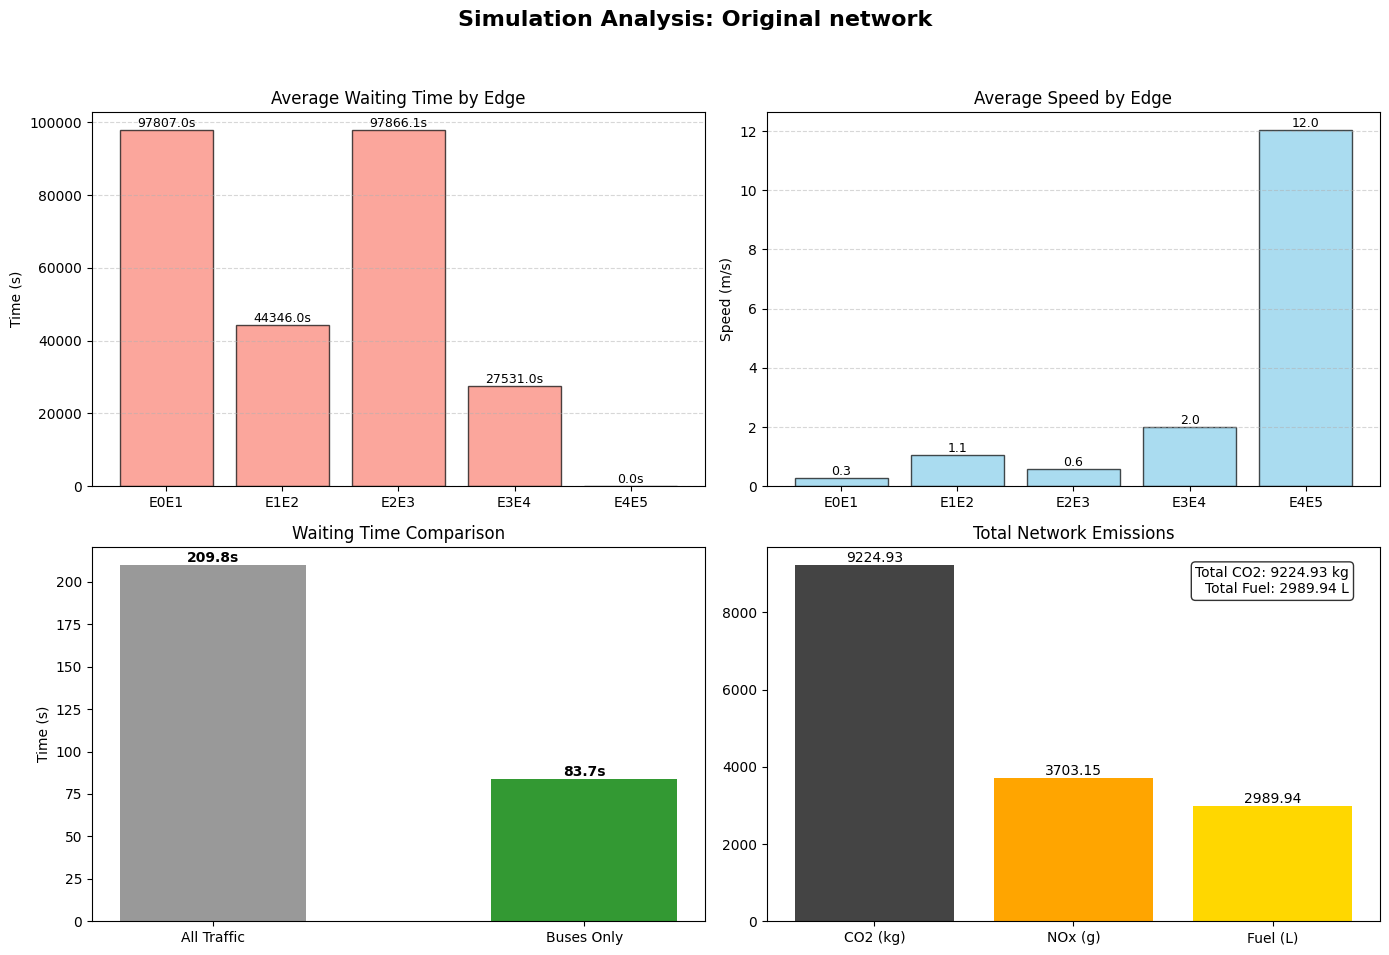

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# CONFIGURATION
# ==========================================
# The JSON file created by the previous script
INPUT_FILE = "original_network_kpis.json"


def load_data(filename):
    if not os.path.exists(filename):
        print(f"Error: The file '{filename}' was not found.")
        print("Make sure to run the analysis script first!")
        return None
    
    with open(filename, 'r') as f:
        return json.load(f)

def create_dashboard(data):
    # Setup the figure grid (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Simulation Analysis: {os.path.basename(data['scenario_path'])}", fontsize=16, fontweight='bold')
    
    # -------------------------------------------------------
    # 1. Edge Analysis: Waiting Time (Top Left)
    # -------------------------------------------------------
    ax1 = axes[0, 0]
    edges = list(data['edges'].keys())
    # Extract waiting times, defaulting to 0 if missing
    wait_times = [d.get('waitingTime', 0) for d in data['edges'].values()]
    
    # Create bar chart
    bars1 = ax1.bar(edges, wait_times, color='salmon', edgecolor='black', alpha=0.7)
    
    ax1.set_title('Average Waiting Time by Edge')
    ax1.set_ylabel('Time (s)')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add values on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

    # -------------------------------------------------------
    # 2. Edge Analysis: Average Speed (Top Right)
    # -------------------------------------------------------
    ax2 = axes[0, 1]
    speeds = [d.get('speed', 0) for d in data['edges'].values()]
    
    bars2 = ax2.bar(edges, speeds, color='skyblue', edgecolor='black', alpha=0.7)
    
    ax2.set_title('Average Speed by Edge')
    ax2.set_ylabel('Speed (m/s)')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    # -------------------------------------------------------
    # 3. Global vs Bus Performance (Bottom Left)
    # -------------------------------------------------------
    ax3 = axes[1, 0]
    
    # Data preparation
    categories = ['All Traffic', 'Buses Only']
    avg_waits = [
        data['global_traffic'].get('avg_waiting', 0),
        data['bus_specific'].get('avg_waiting', 0)
    ]
    
    # Color condition: Green if Bus is faster (less wait), Red if slower
    bus_color = 'green' if avg_waits[1] < avg_waits[0] else 'red'
    colors = ['gray', bus_color]
    
    bars3 = ax3.bar(categories, avg_waits, color=colors, alpha=0.8, width=0.5)
    
    ax3.set_title('Waiting Time Comparison')
    ax3.set_ylabel('Time (s)')
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # -------------------------------------------------------
    # 4. Emissions Summary (Bottom Right)
    # -------------------------------------------------------
    ax4 = axes[1, 1]
    
    emissions = data.get('emissions', {})
    if emissions:
        # Normalize for visualization (log scale might be better, but simple bar here)
        metrics = ['CO2 (kg)', 'NOx (g)', 'Fuel (L)'] # displaying NOx in grams for visibility
        
        # Prepare values (Convert NOx kg -> g for better visibility on chart)
        values = [
            emissions.get('CO2_kg', 0),
            emissions.get('NOx_kg', 0) * 1000, 
            emissions.get('Fuel_L', 0)
        ]
        
        bars4 = ax4.bar(metrics, values, color=['#444444', '#FFA500', '#FFD700'])
        ax4.set_title('Total Network Emissions')
        
        # Add labels
        for i, v in enumerate(values):
            ax4.text(i, v, f'{v:.2f}', ha='center', va='bottom')
            
        # Add text box with raw data
        stats_text = (f"Total CO2: {values[0]:.2f} kg\n"
                      f"Total Fuel: {values[2]:.2f} L")
        ax4.text(0.95, 0.95, stats_text, transform=ax4.transAxes, 
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax4.text(0.5, 0.5, "No Emission Data Available", ha='center')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the plot
    output_img = "current_kpi_dashboard.png"
    plt.savefig(output_img, dpi=300)
    print(f"Graph saved as: {output_img}")
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    kpi_data = load_data(INPUT_FILE)
    
    if kpi_data:
        print("Generatig dashboard...")
        create_dashboard(kpi_data)

ATTENZIONE: Non trovo C:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_PROJECT_2\Original network results
Provo a cercare nella cartella 'Original network' senza 'results'...
Lettura dati da: C:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_PROJECT_2\Original network...
Analisi su 7315 veicoli e 80 archi stradali.
Generazione Grafico 1...
 -> Creato: Graph1_Bus_Performance.png
Generazione Grafico 2...
 -> Creato: Graph2_Network_Impact.png
Generazione Grafico 3...
 -> Creato: Graph3_Bottlenecks.png
Generazione Grafico 4...
 -> Creato: Graph4_Efficiency_Scatter.png

[Fatto] Tutti i grafici sono stati salvati nella cartella del progetto.


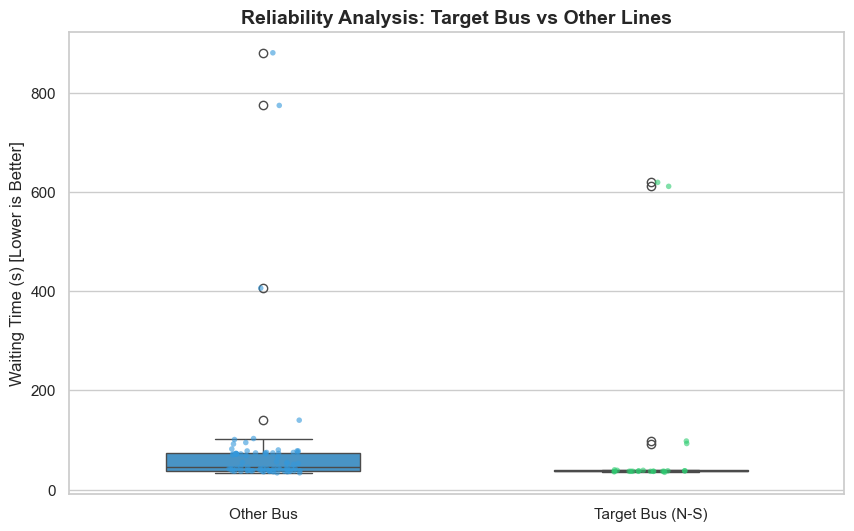

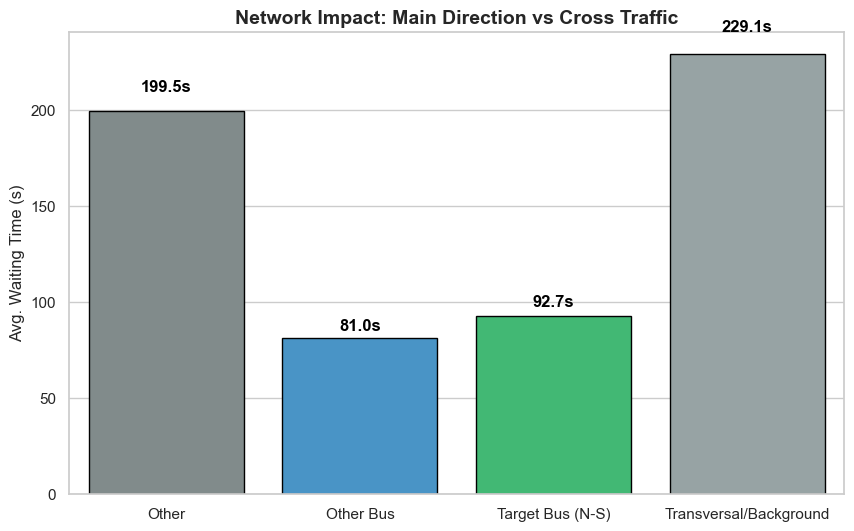

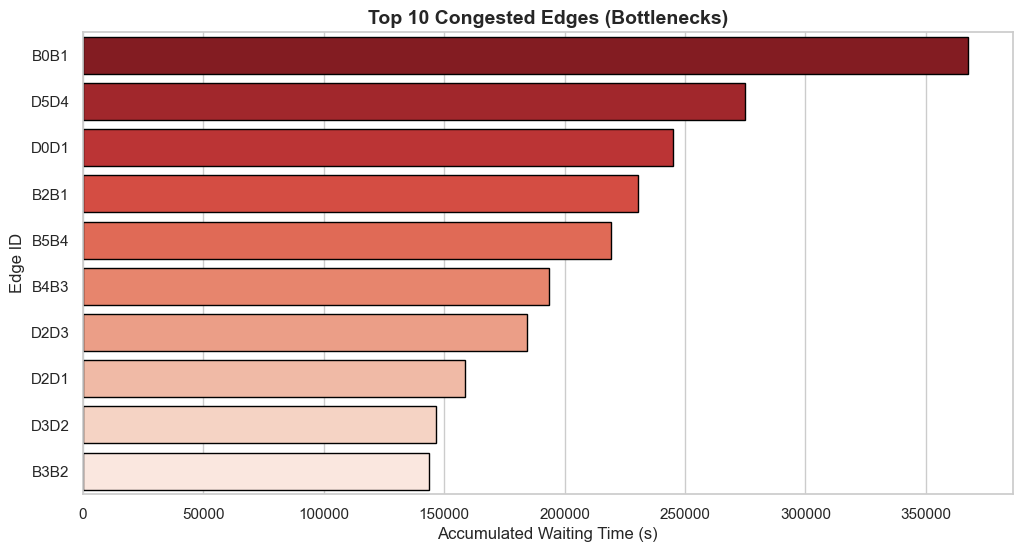

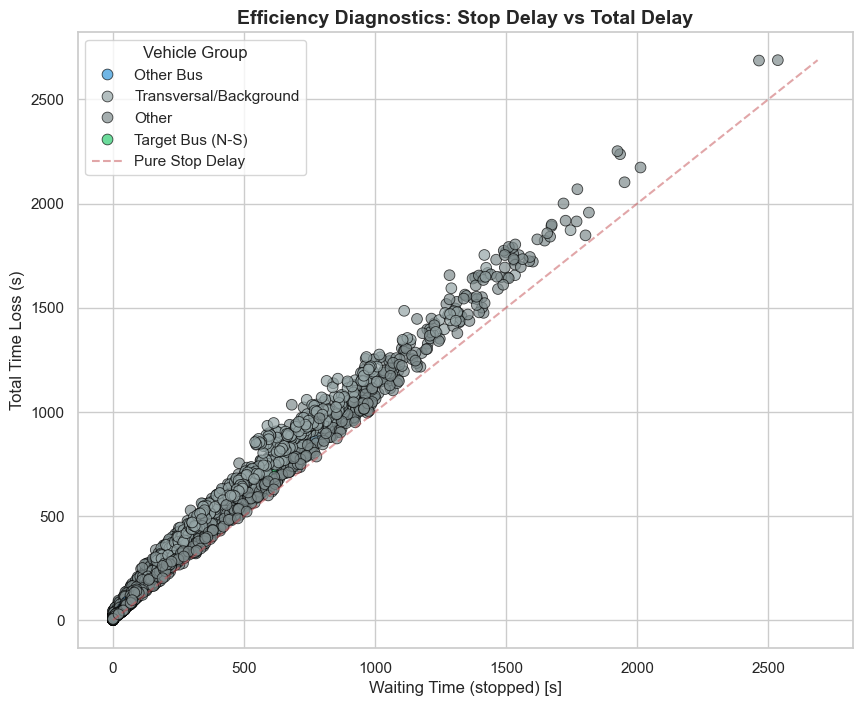

In [8]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. CONFIGURAZIONE E MAPPATURA
# ==========================================
# IMPORTANTE: Assicurati che questo nome corrisponda alla cartella reale
# Dal tuo errore vedo che il percorso finisce con "Original network" (senza results?)
# Modifica questa stringa se necessario.
RESULTS_FOLDER = "Original network results" 

def classify_vehicle(veh_id):
    """
    Classifica i veicoli in base al loro ID.
    """
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    if prefix in ['f_6', 'f_7']:
        return "Target Bus (N-S)", "Bus"
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal/Background", "Traffic" 
    else:
        # Tutto il resto (es. auto generate casualmente o altri flussi)
        return "Other", "Traffic"

# ==========================================
# 2. ESTRAZIONE DATI
# ==========================================
def load_simulation_data(folder):
    trip_file = os.path.join(folder, "tripinfo.xml")
    edge_file = os.path.join(folder, "bus_results.xml") # Controlla se si chiama bus_results.xml o edgedata.xml
    
    # --- 1. Caricamento Tripinfo (Veicoli) ---
    if not os.path.exists(trip_file):
        raise FileNotFoundError(f"Non trovo il file: {trip_file}")
        
    tree = ET.parse(trip_file)
    trips = []
    for trip in tree.getroot().findall('tripinfo'):
        v_id = trip.get('id')
        category, v_type = classify_vehicle(v_id)
        
        trips.append({
            'id': v_id,
            'category': category,
            'type': v_type,
            'waitingTime': float(trip.get('waitingTime')),
            'timeLoss': float(trip.get('timeLoss')),
            'duration': float(trip.get('duration')),
            'routeLength': float(trip.get('routeLength', 0))
        })
    df_trips = pd.DataFrame(trips)
    
    # --- 2. Caricamento Edge Data (Strade) ---
    edges_data = []
    if os.path.exists(edge_file):
        tree_edge = ET.parse(edge_file)
        # Cerca l'ultimo intervallo disponibile
        intervals = tree_edge.getroot().findall('interval')
        if intervals:
            last_interval = intervals[-1]
            for edge in last_interval.findall('edge'):
                edges_data.append({
                    'edge_id': edge.get('id'),
                    'waitingTime': float(edge.get('waitingTime', 0)),
                    'speed': float(edge.get('speed', 0)),
                    'density': float(edge.get('density', 0))
                })
        else:
            print("Avviso: File edge data trovato ma vuoto o senza intervalli.")
    else:
        print(f"Avviso: File {edge_file} non trovato. Il grafico dei colli di bottiglia sarà vuoto.")
        
    df_edges = pd.DataFrame(edges_data)
    
    return df_trips, df_edges

# ==========================================
# 3. GENERAZIONE GRAFICI PER PRESENTAZIONE
# ==========================================
def generate_presentation_plots(df_trips, df_edges):
    # Impostiamo lo stile grafico
    sns.set_theme(style="whitegrid")
    
    # CORREZIONE ERRORE PALETTE:
    # Aggiungiamo esplicitamente il colore per "Other"
    palette = {
        "Target Bus (N-S)": "#2ecc71",       # Verde (I nostri bus)
        "Other Bus": "#3498db",              # Blu (Altri bus)
        "Transversal/Background": "#95a5a6", # Grigio (Traffico trasversale)
        "Other": "#7f8c8d"                   # Grigio scuro (Tutto il resto)
    }
    
    # --- FIGURA 1: Performance Bus Target vs Altri ---
    print("Generazione Grafico 1...")
    plt.figure(figsize=(10, 6))
    
    bus_data = df_trips[df_trips['type'] == 'Bus']
    
    if not bus_data.empty:
        # Sintassi aggiornata per evitare FutureWarning (hue=category, legend=False)
        sns.boxplot(x="category", y="waitingTime", hue="category", data=bus_data, palette=palette, width=0.5, legend=False)
        sns.stripplot(x="category", y="waitingTime", hue="category", data=bus_data, palette=palette, size=4, alpha=0.6, legend=False)
        
        plt.title("Reliability Analysis: Target Bus vs Other Lines", fontsize=14, fontweight='bold')
        plt.ylabel("Waiting Time (s) [Lower is Better]")
        plt.xlabel("")
        plt.savefig("Graph1_Bus_Performance.png", dpi=300, bbox_inches='tight')
        print(" -> Creato: Graph1_Bus_Performance.png")
    else:
        print(" -> Saltato (Nessun dato Bus trovato)")

    # --- FIGURA 2: Impatto sulla Rete (Direzione vs Trasversale) ---
    print("Generazione Grafico 2...")
    plt.figure(figsize=(10, 6))
    
    summary = df_trips.groupby('category')['waitingTime'].mean().reset_index()
    
    # Sintassi aggiornata
    bar = sns.barplot(x="category", y="waitingTime", hue="category", data=summary, palette=palette, edgecolor="black", legend=False)
    
    for index, row in summary.iterrows():
        # Gestione posizionamento testo dinamico
        bar.text(index, row.waitingTime + (row.waitingTime * 0.05), f'{row.waitingTime:.1f}s', color='black', ha="center", fontweight='bold')
        
    plt.title("Network Impact: Main Direction vs Cross Traffic", fontsize=14, fontweight='bold')
    plt.ylabel("Avg. Waiting Time (s)")
    plt.xlabel("")
    plt.savefig("Graph2_Network_Impact.png", dpi=300, bbox_inches='tight')
    print(" -> Creato: Graph2_Network_Impact.png")

    # --- FIGURA 3: Bottleneck Detection (Top 10 Edges) ---
    print("Generazione Grafico 3...")
    if not df_edges.empty:
        plt.figure(figsize=(12, 6))
        
        top_edges = df_edges.sort_values(by='waitingTime', ascending=False).head(10)
        
        # Qui usiamo una palette diversa (Reds) perché non è legata alle categorie veicoli
        sns.barplot(x="waitingTime", y="edge_id", hue="edge_id", data=top_edges, palette="Reds_r", edgecolor="black", legend=False)
        
        plt.title("Top 10 Congested Edges (Bottlenecks)", fontsize=14, fontweight='bold')
        plt.xlabel("Accumulated Waiting Time (s)")
        plt.ylabel("Edge ID")
        plt.savefig("Graph3_Bottlenecks.png", dpi=300, bbox_inches='tight')
        print(" -> Creato: Graph3_Bottlenecks.png")
    else:
        print(" -> Saltato (Nessun dato Edge trovato)")

    # --- FIGURA 4: Efficiency Scatter (Waiting vs TimeLoss) ---
    print("Generazione Grafico 4...")
    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(data=df_trips, x="waitingTime", y="timeLoss", hue="category", palette=palette, s=60, alpha=0.7, edgecolor="black")
    
    max_val = max(df_trips['waitingTime'].max(), df_trips['timeLoss'].max()) if not df_trips.empty else 100
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label="Pure Stop Delay")
    
    plt.title("Efficiency Diagnostics: Stop Delay vs Total Delay", fontsize=14, fontweight='bold')
    plt.xlabel("Waiting Time (stopped) [s]")
    plt.ylabel("Total Time Loss (s)")
    plt.legend(title="Vehicle Group")
    plt.savefig("Graph4_Efficiency_Scatter.png", dpi=300, bbox_inches='tight')
    print(" -> Creato: Graph4_Efficiency_Scatter.png")

# ==========================================
# 4. ESECUZIONE
# ==========================================
if __name__ == "__main__":
    try:
        # Definisci qui il percorso base del tuo progetto
        # Nota: se "MOCOM_PROJECT_2" è la cartella principale, punta lì.
        base_dir = r"C:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_PROJECT_2"
        
        # Combina con la cartella dei risultati
        target_dir = os.path.join(base_dir, RESULTS_FOLDER)
        
        # Check se esiste, altrimenti prova senza 'results' nel caso ti fossi sbagliato
        if not os.path.exists(target_dir):
            print(f"ATTENZIONE: Non trovo {target_dir}")
            print("Provo a cercare nella cartella 'Original network' senza 'results'...")
            target_dir = os.path.join(base_dir, "Original network")
        
        print(f"Lettura dati da: {target_dir}...")
        trips, edges = load_simulation_data(target_dir)
        
        print(f"Analisi su {len(trips)} veicoli e {len(edges)} archi stradali.")
        generate_presentation_plots(trips, edges)
        
        print("\n[Fatto] Tutti i grafici sono stati salvati nella cartella del progetto.")
        
    except Exception as e:
        print(f"\nERRORE CRITICO: {e}")
        import traceback
        traceback.print_exc()

Reading data from: c:\Users\alera\Desktop\ENTPE\MoCoM\MOCOM_project_2\Original network
Salvato: Analysis_Bidirectional_Edges_v2.png
Salvato: Analysis_Bidirectional_KPIs_v2.png


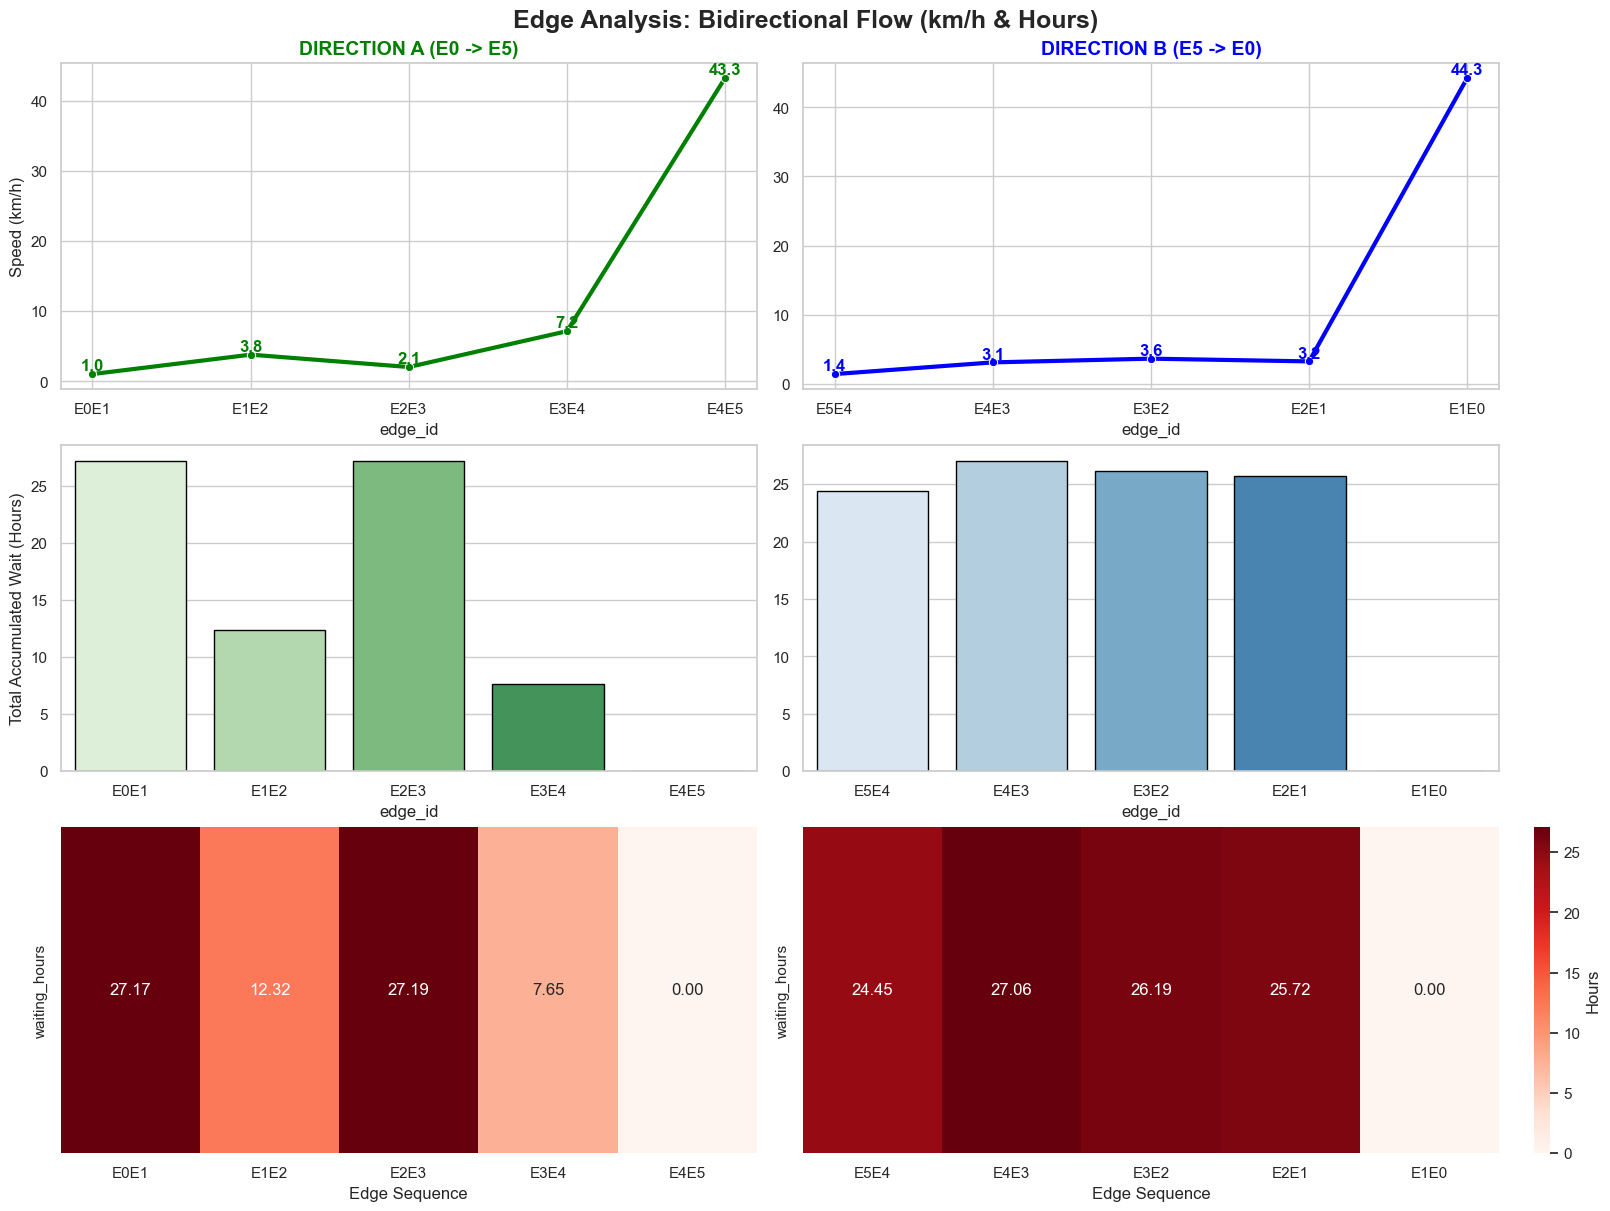

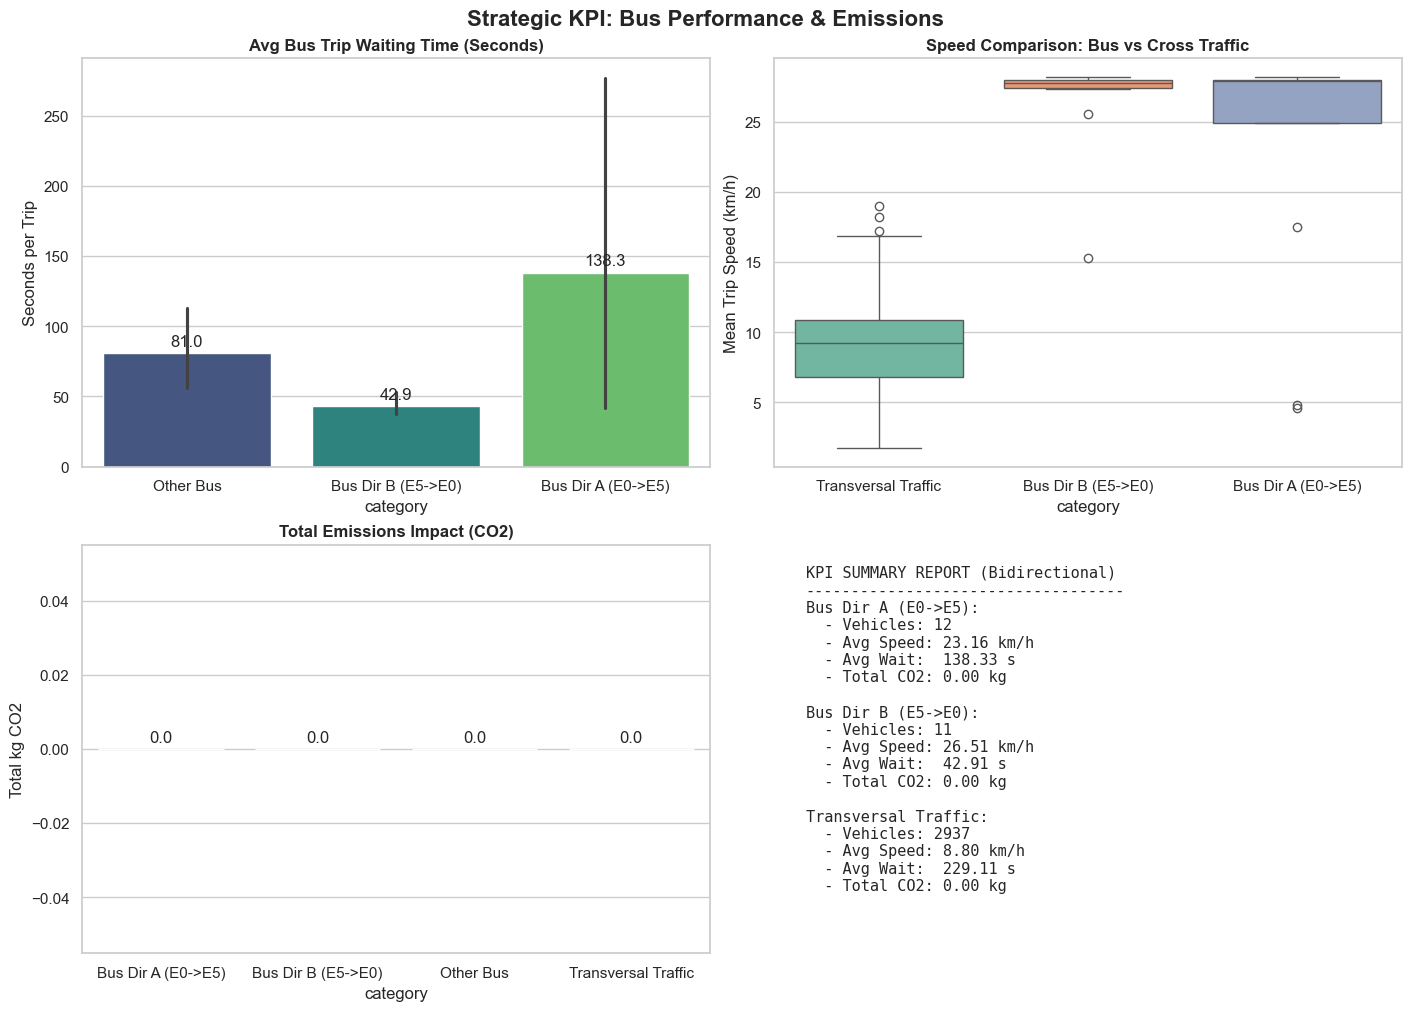

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. CONFIGURAZIONE
# ==========================================
RESULTS_FOLDER = "Original network"

# DEFINIZIONE DELLE DUE DIREZIONI
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"] # Andata
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"] # Ritorno

# CLASSIFICAZIONE VEICOLI
def classify_vehicle(veh_id):
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- DIREZIONE A (E0 -> E5) ---
    if prefix in ['f_7']: 
        return "Bus Dir A (E0->E5)", "Bus", "Dir A"
    
    # --- DIREZIONE B (E5 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus Dir B (E5->E0)", "Bus", "Dir B"
        
    # --- ALTRI ---
    elif prefix in ['f_4', 'f_5']:
        return "Other Bus", "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Transversal Traffic", "Traffic", "Transversal"
    else:
        return "Background", "Car", "Other"

# ==========================================
# 2. CARICAMENTO DATI
# ==========================================
def load_data(folder):
    trip_path = os.path.join(folder, "tripinfo.xml")
    edge_path = os.path.join(folder, "bus_results.xml")

    # --- 1. TRIPINFO (Veicoli singoli) ---
    trips = []
    if os.path.exists(trip_path):
        tree = ET.parse(trip_path)
        for t in tree.getroot().findall('tripinfo'):
            cat, vtype, route_group = classify_vehicle(t.get('id'))
            
            # GESTIONE CO2: SUMO usa CO2_abs (mg)
            co2_mg = float(t.get('CO2_abs', 0))
            if co2_mg == 0:
                co2_mg = float(t.get('CO2', 0)) # Fallback
            
            duration = float(t.get('duration'))
            route_len = float(t.get('routeLength', 0))
            
            # Calcolo velocità media viaggio in km/h
            speed_kmh = (route_len / duration) * 3.6 if duration > 0 else 0

            trips.append({
                'id': t.get('id'),
                'category': cat,
                'type': vtype,
                'route_group': route_group,
                'waitingTime': float(t.get('waitingTime')), # Rimane in secondi (per singolo viaggio)
                'duration': duration,
                'routeLength': route_len,
                'speed_kmh': speed_kmh,
                'co2_kg': co2_mg / 1_000_000 # Convertiamo mg -> kg
            })
    df_trips = pd.DataFrame(trips)

    # --- 2. EDGE DATA (Strade) ---
    edges_stats = []
    if os.path.exists(edge_path):
        tree = ET.parse(edge_path)
        intervals = tree.getroot().findall('interval')
        if intervals:
            # Usiamo l'ultimo intervallo
            for e in intervals[-1].findall('edge'):
                eid = e.get('id')
                direction = "None"
                order = 99
                
                if eid in DIR_A_EDGES:
                    direction = "Dir A (E0->E5)"
                    order = DIR_A_EDGES.index(eid)
                elif eid in DIR_B_EDGES:
                    direction = "Dir B (E5->E0)"
                    order = DIR_B_EDGES.index(eid)
                
                if direction != "None":
                    # Conversioni Unità
                    speed_ms = float(e.get('speed', 0))
                    wait_sec = float(e.get('waitingTime', 0)) # Questo è il totale accumulato
                    
                    edges_stats.append({
                        'edge_id': eid,
                        'direction': direction,
                        'order': order,
                        'speed_kmh': speed_ms * 3.6,        # m/s -> km/h
                        'waiting_hours': wait_sec / 3600.0, # seconds -> hours
                        'density': float(e.get('density', 0))
                    })
    
    df_edges = pd.DataFrame(edges_stats)
    if not df_edges.empty:
        df_edges = df_edges.sort_values(by=['direction', 'order'])

    return df_trips, df_edges

# ==========================================
# 3. VISUALIZZAZIONE BIDIREZIONALE
# ==========================================
def create_dashboard(df_trips, df_edges):
    sns.set_theme(style="whitegrid")
    
    # Separazione dataset Archi
    df_edges_A = df_edges[df_edges['direction'] == "Dir A (E0->E5)"]
    df_edges_B = df_edges[df_edges['direction'] == "Dir B (E5->E0)"]

    # --- FIGURA 1: ANALISI ARCHI (SPEED & WAIT) ---
    fig1, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
    fig1.suptitle("Edge Analysis: Bidirectional Flow (km/h & Hours)", fontsize=18, fontweight='bold')

    # Titoli colonne
    axes[0,0].set_title("DIRECTION A (E0 -> E5)", fontsize=14, color='green', fontweight='bold')
    axes[0,1].set_title("DIRECTION B (E5 -> E0)", fontsize=14, color='blue', fontweight='bold')

    # ROW 1: SPEED (km/h)
    if not df_edges_A.empty:
        sns.lineplot(data=df_edges_A, x='edge_id', y='speed_kmh', marker='o', color='green', ax=axes[0,0], linewidth=3)
        axes[0,0].set_ylabel("Speed (km/h)")
        for x, y in zip(range(len(df_edges_A)), df_edges_A['speed_kmh']):
            axes[0,0].text(x, y+0.5, f"{y:.1f}", ha='center', color='green', fontweight='bold')
            
    if not df_edges_B.empty:
        sns.lineplot(data=df_edges_B, x='edge_id', y='speed_kmh', marker='o', color='blue', ax=axes[0,1], linewidth=3)
        axes[0,1].set_ylabel("") # Hide label
        for x, y in zip(range(len(df_edges_B)), df_edges_B['speed_kmh']):
            axes[0,1].text(x, y+0.5, f"{y:.1f}", ha='center', color='blue', fontweight='bold')

    # ROW 2: TOTAL ACCUMULATED WAITING TIME (Hours)
    if not df_edges_A.empty:
        sns.barplot(data=df_edges_A, x='edge_id', y='waiting_hours', hue='edge_id', palette="Greens", ax=axes[1,0], legend=False, edgecolor='black')
        axes[1,0].set_ylabel("Total Accumulated Wait (Hours)")
        
    if not df_edges_B.empty:
        sns.barplot(data=df_edges_B, x='edge_id', y='waiting_hours', hue='edge_id', palette="Blues", ax=axes[1,1], legend=False, edgecolor='black')
        axes[1,1].set_ylabel("")

    # ROW 3: HEATMAPS (Hours)
    # Heatmap A
    if not df_edges_A.empty:
        matrix_A = df_edges_A[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_A, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,0], cbar=False)
        axes[2,0].set_xlabel("Edge Sequence")
        
    # Heatmap B
    if not df_edges_B.empty:
        matrix_B = df_edges_B[['edge_id', 'waiting_hours']].set_index('edge_id').T
        sns.heatmap(matrix_B, annot=True, fmt=".2f", cmap="Reds", ax=axes[2,1], cbar_kws={'label': 'Hours'})
        axes[2,1].set_xlabel("Edge Sequence")

    plt.savefig("Analysis_Bidirectional_Edges_v2.png", dpi=300)
    print("Salvato: Analysis_Bidirectional_Edges_v2.png")

    # --- FIGURA 2: CONFRONTO BUS vs RETE ---
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig2.suptitle("Strategic KPI: Bus Performance & Emissions", fontsize=16, fontweight='bold')

    # 1. Waiting Time Comparison (Rimane in secondi per leggibilità del singolo viaggio)
    target_buses = df_trips[df_trips['type'] == 'Bus']
    if not target_buses.empty:
        sns.barplot(data=target_buses, x='category', y='waitingTime', hue='category', palette="viridis", ax=axes[0,0], legend=False)
        axes[0,0].set_title("Avg Bus Trip Waiting Time (Seconds)", fontweight='bold')
        axes[0,0].set_ylabel("Seconds per Trip")
        for c in axes[0,0].containers:
            axes[0,0].bar_label(c, fmt='%.1f', padding=3)

    # 2. Speed Comparison (km/h)
    comp_groups = ["Bus Dir A (E0->E5)", "Bus Dir B (E5->E0)", "Transversal Traffic"]
    speed_df = df_trips[df_trips['category'].isin(comp_groups)]
    
    if not speed_df.empty:
        sns.boxplot(data=speed_df, x='category', y='speed_kmh', hue='category', palette="Set2", ax=axes[0,1], legend=False)
        axes[0,1].set_title("Speed Comparison: Bus vs Cross Traffic", fontweight='bold')
        axes[0,1].set_ylabel("Mean Trip Speed (km/h)")

 # -------------------------------------------------------
    # 4. Emissions Summary (Bottom Right)
    # -------------------------------------------------------
    ax4 = axes[1, 1]
    
    emissions = data.get('emissions', {})
    if emissions:
        # Normalize for visualization (log scale might be better, but simple bar here)
        metrics = ['CO2 (kg)', 'NOx (g)', 'Fuel (L)'] # displaying NOx in grams for visibility
        
        # Prepare values (Convert NOx kg -> g for better visibility on chart)
        values = [
            emissions.get('CO2_kg', 0),
            emissions.get('NOx_kg', 0) * 1000, 
            emissions.get('Fuel_L', 0)
        ]
        
        bars4 = ax4.bar(metrics, values, color=['#444444', '#FFA500', '#FFD700'])
        ax4.set_title('Total Network Emissions')
        
        # Add labels
        for i, v in enumerate(values):
            ax4.text(i, v, f'{v:.2f}', ha='center', va='bottom')
            
        # Add text box with raw data
        stats_text = (f"Total CO2: {values[0]:.2f} kg\n"
                      f"Total Fuel: {values[2]:.2f} L")
        ax4.text(0.95, 0.95, stats_text, transform=ax4.transAxes, 
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax4.text(0.5, 0.5, "No Emission Data Available", ha='center')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the plot
    output_img = "current_kpi_dashboard.png"
    plt.savefig(output_img, dpi=300)
    print(f"Graph saved as: {output_img}")
    plt.show()


    # 4. Text Summary Box
    axes[1,1].axis('off')
    
    text_str = "KPI SUMMARY REPORT (Bidirectional)\n" + "-"*35 + "\n"
    for cat in comp_groups:
        subset = df_trips[df_trips['category'] == cat]
        if not subset.empty:
            avg_wait = subset['waitingTime'].mean()
            avg_speed = subset['speed_kmh'].mean()
            tot_co2 = subset['co2_kg'].sum()
            count = len(subset)
            text_str += f"{cat}:\n"
            text_str += f"  - Vehicles: {count}\n"
            text_str += f"  - Avg Speed: {avg_speed:.2f} km/h\n"
            text_str += f"  - Avg Wait:  {avg_wait:.2f} s\n"
            text_str += f"  - Total CO2: {tot_co2:.2f} kg\n\n"
    
    axes[1,1].text(0.05, 0.95, text_str, fontsize=11, fontfamily='monospace', verticalalignment='top', 
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

    plt.savefig("Analysis_Bidirectional_KPIs_v2.png", dpi=300)
    print("Salvato: Analysis_Bidirectional_KPIs_v2.png")
    plt.show()

# ==========================================
# 4. ESECUZIONE
# ==========================================
if __name__ == "__main__":
    base_dir = os.getcwd()
    target_dir = os.path.join(base_dir, RESULTS_FOLDER)
    
    if not os.path.exists(target_dir):
        # Fallback path
        target_dir = os.path.join(base_dir, "MOCOM_project_2", RESULTS_FOLDER)

    print(f"Reading data from: {target_dir}")
    try:
        trips, edges = load_data(target_dir)
        create_dashboard(trips, edges)
    except Exception as e:
        print(f"ERRORE: {e}")
        import traceback
        traceback.print_exc()